In [1]:
import numpy as np
from numpy import pi
from numpy.fft import rfftfreq, rfft, irfft
from numpy.random import default_rng

from scipy import odr
import scipy.linalg as la
from scipy.optimize import least_squares
from scipy.stats import cumfreq, chi2, norm, probplot

from matplotlib import pyplot as plt
from matplotlib.figure import figaspect

from thztools import thzgen, noiseamp, costfunlsq, ODR

The transfer function model function `tf_model` returns
 $$ H(\mathbf{\theta}; \omega) = \theta_0\exp(-i\omega\theta_1),$$
 which rescales the input by $\theta_0$ and shifts it by $\theta_1$ (using the $+i\omega t$ sign convention). In the simulations, $\theta_0 = 1$ and $\theta_1 = 0$. The time-domain response function `td_model` applies this transfer function to a signal vector $x(t)$ for a given $\mathbf{\theta}$ and returns the resulting $y(t)$, as shown in the second cell for $\theta_0 = 0.5, \theta_1 = 1.0$.

In [2]:
def tf_model(_p, _w):
    return _p[0] * np.exp(-1j * _w * _p[1])

In [3]:
n = 256  # Number of samples
ts = 0.05  # Sampling time [ps]
t0 = 2.5  # Peak pulse time [ps]
fs = 1 / ts  # Sampling frequency [THz]

sigma_alpha = 1e-4  # Additive noise amplitude [signal units]
sigma_beta = 1e-2  # Multiplicative noise amplitude [dimensionless]
sigma_tau = 1e-3  # Time base noise amplitude [ps]
sigma_parms = np.array([sigma_alpha, sigma_beta, sigma_tau])

seed = 0  # RNG seed
rng = default_rng(seed)

The ODRPACK documentation defines $X = X^* - \Delta^*$ and $Y = Y^* - E^*$, where the starred quantities indicate the true values.

In [4]:
n_sim = 250
p_opt = (0.5, 1)
f = rfftfreq(n, ts)


def td_model(_p, _x):
    _y = irfft(rfft(_x) * tf_model(_p, 2 * pi * f), n=n)
    return _y


mu, t = thzgen(n, ts, t0)
psi = td_model(p_opt, mu)
sigma_mu = noiseamp(sigma_parms, mu, ts)
sigma_psi = noiseamp(sigma_parms, psi, ts)
x_noise = sigma_mu * rng.standard_normal((n_sim, n))
y_noise = sigma_psi * rng.standard_normal((n_sim, n))

x = mu - x_noise
y = psi - y_noise

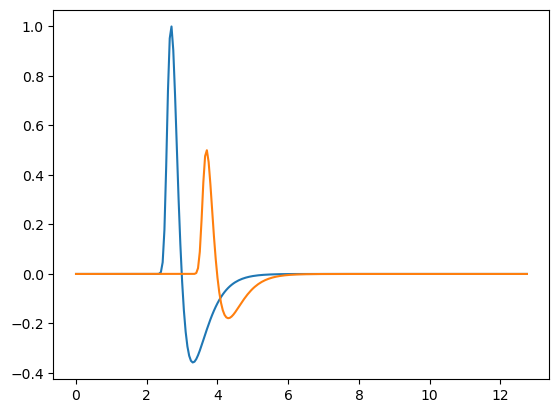

In [5]:
plt.plot(t, mu)
plt.plot(t, psi)
plt.show()

For multivariate data, `ODRPACK` solves the orthogonal distance regression problem for
$$f_i: \mathbb{R}^{m+p}\rightarrow \mathbb{R}^{q},\quad i = 0, 1, \ldots, n_\text{vec} -1, $$
where $n_\text{vec}$ is the number of data vectors, and in our case $m = q = n$, where $n$ is the number of data points in each vector. The error vectors $\mathbf{\delta}_i$ and $\mathbf{\epsilon}_i$, associated with $\mathbf{x}_i$ and $\mathbf{y}_i$, respectively, may also be weighted by the arrays $\mathbf{w}_{\mathbf{\delta}_i} \in \mathbb{R}^{m\times m}$ and $\mathbf{w}_{\mathbf{\epsilon}_i} \in \mathbb{R}^{q\times q}$, respectively.

The documentation for `scipy.odr` does not completely specify how this data should be organized for passing to `ODRPACK`, but it appears that the `Data` class expects `x` to have shape $(m, n_\text{vec})$, `y` to have shape $(q, n_\text{vec})$, `we` to have shape $(q, q, n_\text{vec})$, and `wd` to have shape $(m, m, n_\text{vec})$.

In [6]:
n_vec = 2
sigma_x = noiseamp(sigma_parms, mu, ts)
sigma_y = noiseamp(sigma_parms, psi, ts)

def td_model_2(_p, _x):
    _y = irfft(rfft(_x.T) * tf_model(_p, 2 * pi * f), n=n)
    return _y.T


model = odr.Model(td_model_2)
x_test = np.atleast_2d(x[:n_vec, :]).T
y_test = np.atleast_2d(y[:n_vec, :]).T
delta_0 = np.atleast_2d(x_noise[:n_vec, :]).T
we = np.transpose(np.tile(np.diag(1 / sigma_y ** 2), (n_vec, 1, 1)), (1, 2, 0))
wd = np.transpose(np.tile(np.diag(1 / sigma_x ** 2), (n_vec, 1, 1)), (1, 2, 0))
data = odr.Data(x_test,
                y=y_test,
                we=we,
                wd=wd)
print(x_test.shape)
print(y_test.shape)
print(we.shape)
print(wd.shape)
fit = ODR(data, model, beta0=p_opt, delta0=delta_0)
fit.set_job(del_init=1)
result = fit.run()
print(result.info)
print(result.stopreason)
print(result.beta)

(256, 2)
(256, 2)
(256, 256, 2)
(256, 256, 2)
1
['Sum of squares convergence']
[0.50007947 0.99970994]


Our fit fails when $n_\text{vec} = 1$, since `ODRPACK` expects $n_\text{vec} \geq p$.

In [7]:
n_vec = 1
sigma_x = noiseamp(sigma_parms, mu, ts)
sigma_y = noiseamp(sigma_parms, psi, ts)

def td_model_2(_p, _x):
    _y = irfft(rfft(_x.T) * tf_model(_p, 2 * pi * f), n=n)
    return _y.T


model = odr.Model(td_model_2)
x_test = np.atleast_2d(x[:n_vec, :]).T
y_test = np.atleast_2d(y[:n_vec, :]).T
delta_0 = np.atleast_2d(x_noise[:n_vec, :]).T
we = np.transpose(np.tile(np.diag(1 / sigma_y ** 2), (n_vec, 1, 1)), (1, 2, 0))
wd = np.transpose(np.tile(np.diag(1 / sigma_x ** 2), (n_vec, 1, 1)), (1, 2, 0))
data = odr.Data(x_test,
                y=y_test,
                we=we,
                wd=wd)
print(x_test.shape)
print(y_test.shape)
print(we.shape)
print(wd.shape)
fit = ODR(data, model, beta0=p_opt, delta0=delta_0)
fit.set_job(del_init=1)
result = fit.run()
print(result.info)
print(result.stopreason)
print(result.beta)

(256, 1)
(256, 1)
(256, 256, 1)
(256, 256, 1)
10010
['NP < 1 or NP > N']
[0.5 1. ]
